# 00 - Baseline Classifier

We have a dataset of 42,372 consumers with a roughly 91-9 split between regular consumers (the negative class - `0`) and thieves (the target or positive class `1`). 

This begs the question: when 91% of the consumers will be regular consumers, why even have a machine learning model to differentiate between the two classes? Why not **always predict 0**? 

This is going to be the rationale behind our **baseline classifier**: a model that we will use to establish a benchmark (in terms of some quantifiable metric) to justify the need (or lack thereof) of a machine learning model.

## Setting up Workspace

In [1]:
# For loading and manipulating data
import numpy as np
import pandas as pd

# Seed random number generator
np.random.seed(42)

# Matplotlib with ggplot styles
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# Seaborn for distribution plots
from seaborn import distplot

# Please stop with the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
df = pd.read_csv('../data-final.csv')

In [3]:
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [5]:
df = df.drop(['CONS_NO'], axis=1)

In [11]:
NUM_CONSUMERS = len(df['FLAG'])
NUM_DAYS = len(df.columns) - 1

## Extracting Targets and Labels

In [12]:
labels = df['FLAG']
features = df.drop(['FLAG'], axis=1)

In [13]:
assert len(labels) == len(features)

In [14]:
features.shape

(42372, 1034)

In [15]:
assert features.shape[1] == NUM_DAYS

## Stratified Random Sampling 

To ensure both the training and validation data have the same proportions of positive and negative training examples, we will use stratified random sampling.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                   test_size=0.2,
                                                   shuffle=True, 
                                                   stratify=labels)

In [18]:
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))
assert(X_train.shape[1] == NUM_DAYS)

Text(0.5, 1.0, 'Class Distribution - Training Set')

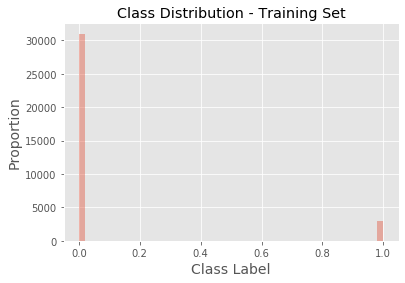

In [19]:
# Exploring distribution of values
distplot(y_train, kde=False)
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Class Distribution - Training Set')

Text(0.5, 1.0, 'Class Distribution - Test Set')

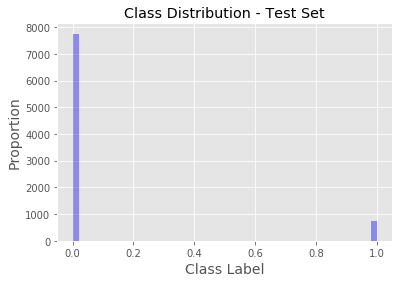

In [20]:
distplot(y_test, kde=False, color='blue')
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Class Distribution - Test Set')

## Baseline Classifier

In [21]:
NUM_TRAIN_SAMPLES = len(X_train)
NUM_TEST_SAMPLES = len(X_test)

In [22]:
# Predictions will be zero regardless of the model
y_pred_train = np.zeros((NUM_TRAIN_SAMPLES, 1))
y_pred_test = np.zeros((NUM_TEST_SAMPLES, 1))

## Evaluating Performance

Zheng's metrics for evaluating classifier performance are
1. **AUC Score**: Area under the model's receiver operating characteristics curve. In other words, a plot of **True Positive Rate (TPR)** (y-axis) against the **False Positive Rate (FPR)**. 
$$TPR_{max} \in [0, 1.0]$$
$$FPR_{max} \in [0, 1.0]$$
$$\therefore AUC_{max} = [0, 1.0]$$

Visually, this means the graph of TPR against FPR will 'hug' the top-left corner of the ROC axes.

2. **Mean Average Precision (MAP)**: This is magic. I do not understand it.

Additionally, I will also use the following metrics
3. **Precision**: A measure of the number of true positives in all predicted positives. In other words, of all the examples predicted to belong to the positive class, which ones actually belonged to the positive class?
$$Precision = \frac{TP}{TP + FP}$$

4. **Recall**: Of all the positive class samples in the set, how many were actually detected? 
$$Recall = \frac{TP}{TP + FN}$$

5. **F1-Score**: Weighted harmonic mean of the precision and recall. Precision and recall are a tradeoff - can't have max precision AND max recall, although the ideal model would have both. This means when evaluating the performance of a classification model, a high precision is useless if recall is very low, and vice versa. F1 score will only be high when both of these metrics are high. 
$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$
$$ \Rightarrow F_1 = \frac{TP}{TP + \frac{FN + FP}{2}}$$

Precision, Recall, and F-1 score can all be predicted with a confusion matrix.

In [49]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from seaborn import light_palette

In [79]:
def get_classification_result(y_pred, y_true, classifier_name=None):
    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves']))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    conf_mat = pd.DataFrame(data=confusion_matrix(y_true, y_pred))
    conf_mat.index = ['True 0', 'True 1']
    conf_mat.columns = ['Predicted 0', 'Predicted 1']
    cm = light_palette('blue', as_cmap=True)
    conf_mat_display = conf_mat.style.background_gradient(cmap=cm)
    display(conf_mat_display)
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.91      1.00      0.96      7752
         Thieves       0.00      0.00      0.00       723

       micro avg       0.91      0.91      0.91      8475
       macro avg       0.46      0.50      0.48      8475
    weighted avg       0.84      0.91      0.87      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7752,0
True 1,723,0


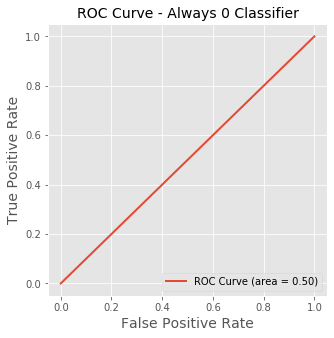

In [80]:
get_classification_result(y_pred_test, y_test, 'Always 0 Classifier')

## Interpretation
- The ROC curve is exactly what I would expect for this classifier.
    - It is a straight line going from 0.0 to 1.0.
    - The are under the curve is 0.50.
- Precision, recall, and F1 score for the non-target class/negative class are very high
    - This makes sense because there is a large number of true positives for this class, and a very small number of alse positives. 
    - Recall is a perfect 1.00 - this is because there are no false negatives.
- Precision, recall, and F1 score for the target class are terrible.
    - All zeroes. 
    - Could be an error in the way I have implemented this. 
    - Need someone to check this.